# Piezo Antenna

In [2]:
import matplotlib.pyplot as plt
import scipy.io.wavfile as wav
import scipy.signal as signal
import numpy as np
import pandas as pd
import os
import re
%matplotlib inline

## Introduction

Most insects utilize a pair of antennae to sense their near-range environment. When blindfolded these insects are still capable of climbing obstacles and finding footholds for their front legs using their antennae [[Dürr01]](https://www.ncbi.nlm.nih.gov/pubmed/22098903). Different types of mechanoreceptors present in each antenna, are involved to perform this kind of orientation. One of these receptors - the Johnston's organ - is correlated to the sensing of antennal vibrations [[JC96]](https://link.springer.com/article/10.1007/BF02346378).
As vibrations are characterized by their amplitude, frequency and phase, all further information about the origin of the vibration is encoded in these properties. This includes forces applied to the antenna on movement or on a contact with another object.
Prior approaches to construct a biomimetic antenna have proven, that vibration characteristics can be exploited to estimate a position of a contact on the antenna or material properties and texture of any touched object [[KM04]](http://www.ti.uni-bielefeld.de/downloads/publications/whisker3.pdf). .....

> Therefore an artificial antenna needs to be constructed that is capable of providing distance information of objects with sufficient precision and a small latency. For footstep planning, the robot needs to get an immediate feedback of it’s surroundings, especially when the knowledge is restricted to the range of the robot. In the hereinafter described experiment, the properties and performance of an antenna that utilizes a piezoelectric sensor gets explored. More precisely it is examined, whether the signal from this antenna contains the required distance estimation on objects it touches.

---
### Konzept
 - antennae as a common concept for near-range orientation
 - mechanoreceptors, especially the johnston's organ
     - vibration sensitivity of antennae
 - prior approaches to construct a biomimetic antenna
     - results of these approaches
     - drawbacks of these approaches
 - what is different in this approach
 - focus on the frequency -> minimize other factors such as amplitude
 - which frequency bands contain most distance information
     - why is it important
         - latency
         - sensor construction (freq response)

## Materials and Methods
### Experimental setup

<table>
  <tr>
    <td> <img src="figures/exp_setup.png" alt="Drawing" style="width: 250px;"/> </td>
    <td> <img src="figures/closeup_motor.png" alt="Drawing" style="width: 250px;"/> </td>
  </tr>
</table>

 - Polyactyllic tube as the antenna
 - Piezoelectric pickup to record vibrations of the antenna as an audio signal
 - Servo-motor *Dynamixel XL-320* to drive the antenna up and down (only vertically)


### Data acquisition

<span><img src="figure_data/setup_oscillator.svg" alt="Drawing" style="width: 600px;"/></span>

#### Contact detection
 - static threshold got defined
 - whenever the recorded amplitude would exceed this value it counts as a contact
 
 
#### Oscillator
To collect the sample data, the antenna was moved upwards and downwards according to a two-phase oscillator that operated as follows:

 - Antenna is going down to induce a contact
 - On contact occourance, the phase is changes to upward movement
 - When a certain maximum angle is reached, the phase is inverted again to downward movement
 - This was repeated until 100 contacts were recorded

### Analytical methods

#### Power spectral density calculation

 - Welch's method
 - takes a time course (audio in this case)
 - slices it into segments
 - applies the Hann window on each segment
 - applies fast fourier transforms on each segment
 - returns the mean spectral density of all segments


   <img src="figure_data/fft.svg" alt="Drawing" style="width: 400px;"/> </td>

#### Support Vector Regression

 - machine learning approach for regression
 - Input: All points of a frequency spectrum
 - Output: Distance
 - Training: supervised
 - finds $\varepsilon$-hypertube minimizing the loss function:
 
<table>
  <tr>
    <td> <img src="figure_data/svr.svg" alt="Drawing" style="width: 300px;"/> </td>
    <td> <img src="figure_data/error-function.svg" alt="Drawing" style="width: 300px;"/> </td>
  </tr>
</table>



First, the recorded data must be read and processed for the analysis.

(6, 6.84)

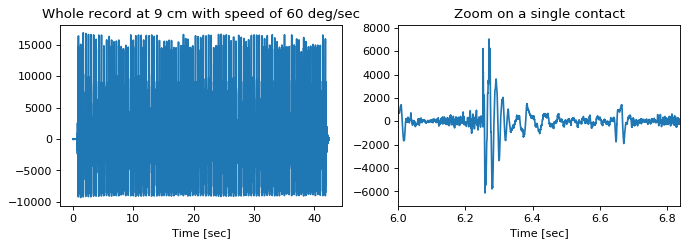

In [3]:
FRAMERATE = 0    # init framerate (gets assigned when wav files are read)

# load and prepare the data
data_dir = 'data'
files = os.listdir(data_dir)
rawdata = pd.DataFrame(columns=['record', 'distance', 'speed'])

def samples_to_time(num_samples):
    '''
    Get a number of samples and outputs the correlating length in time.
    '''
    return np.array(range(num_samples)) / 44100.

# search folder for wav files
id = 0
for f in files:
    if '.wav' not in f:
        continue
    fs, data = wav.read(os.path.join(data_dir, f))
    FRAMERATE = fs
    # parse integers from filename (distance, speed, material)
    decoded_classes = [ int(s) for s in re.findall(r'-?\d+', f) ]
    # put the data into the DataFrame
    rawdata = rawdata.append(dict(
        { 'record'   : data, 
          'distance' : decoded_classes[0],
          'speed'    : decoded_classes[1] }), ignore_index=True)
    id += 1

N_CLASSES = len(rawdata)
rawdata = rawdata.sort_values(by=['distance','speed'])
rawdata['id'] = range(len(rawdata))
rawdata = rawdata.set_index('id', drop=True)
plt.figure(num=None, figsize=(10, 3), dpi=80)

plt.subplot(1, 2, 1)
plt.plot(samples_to_time(len(rawdata['record'][13])),rawdata['record'][13])
plt.xlabel("Time [sec]")
plt.title("Whole record at 9 cm with speed of 60 deg/sec")
plt.subplot(1, 2, 2)
plt.xlabel("Time [sec]")
plt.title("Zoom on a single contact")
plt.plot(samples_to_time(len(rawdata['record'][0])),rawdata['record'][0])
plt.xlim((6, 6.84))

### Extracting the peaks

The records were stored by distance and motor speed. Each file contains 100 recorded contact events and these have to be cut out and stored separately for further processing. Each contact event necessarily exceeds the given threshold, because this principle got also used to detect the contacts in the experimental setup. Due to rebounces and induced vibration, this threshold is exceeded several times during acontact event. Extracting regions of peaks can happen on different ways:
 - The start of a contact is the first transgression of the threshold
 - The start of a contact is the last transgression of the threshold
 - The start of a contact is the max value reached during a contact event.
 
The following implementation allows finding peaks using the first two methods.

In [4]:
EXPECTED_CONTACTS = 100
THRESHOLD = 5000
FRAGMENT_SIZE = 2048
SAMPLES_BETWEEN_CONTACTS = 4410

data = rawdata
    

def find_peaks(x, method='last_peaks'):
    above_th = pd.Series(x) > THRESHOLD
    # find every threshold transgression
    above_th = pd.Series(above_th.index[above_th == True].tolist()).astype(int)
    diff = above_th.diff(periods=-1).abs()
    
    if method == 'first_peaks':
        diff = diff.shift(1).fillna(SAMPLES_BETWEEN_CONTACTS)
    
    peaks_indices = diff.index[diff >= SAMPLES_BETWEEN_CONTACTS].tolist()
    peaks_indices.append(len(above_th) - 1)
    peaks = above_th[peaks_indices].reset_index(drop=True)
    
    return peaks

def extract_peaks(d, peaks):
    idx_peaks = pd.Index(peaks)
    contacts = []
    for c_idx in peaks:
        contacts.append(d[c_idx:c_idx + FRAGMENT_SIZE].tolist())
    return contacts

Number of extracted contacts (99) is not as expected for dist 5 speed 160
Number of extracted contacts (99) is not as expected for dist 7 speed 160


/usr/local/lib/python3.5/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


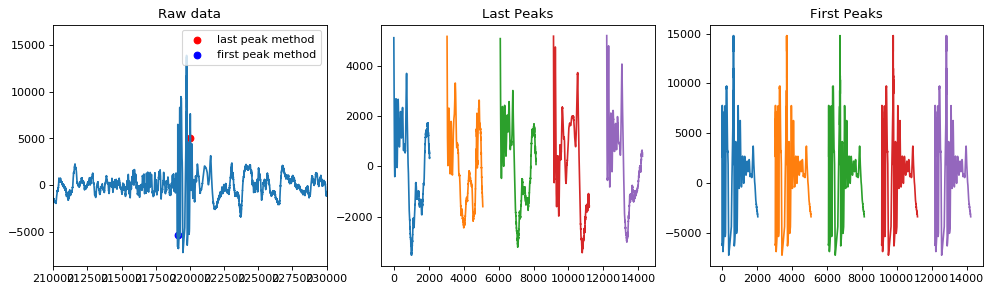

In [5]:
for i in range(N_CLASSES):
    speed = data.loc[i, 'speed']
    distance = data.loc[i, 'distance']
    d = pd.Series(data['record'][i])
    peaks_fst = find_peaks(d.abs(), method='first_peaks')
    data.at[i, 'contacts_fst'] = 0
    data['contacts_fst'] = data['contacts_fst'].astype(object)
    
    data.at[i, 'contacts_fst'] = np.array(extract_peaks(d, peaks_fst))
    peaks_lst = find_peaks(d.abs(), method='last_peaks')
    data.at[i, 'contacts_lst'] = 0
    data['contacts_lst'] = data['contacts_lst'].astype(object)
    data.at[i, 'contacts_lst'] = np.array(extract_peaks(d, peaks_lst)) 
    if len(peaks_lst) != EXPECTED_CONTACTS:
        print("Number of extracted contacts (%d) is not as expected for dist %d speed %d" 
              % (len(peaks_lst), distance, speed))
    
    
plt.figure(num=None, figsize=(15, 4), dpi=80)
plt.subplot('131')
last_series = data['record'][len(data['record'])-1]
plt.title("Raw data")
plt.plot(last_series)
plt.scatter(peaks_lst, [ last_series[i] for i in peaks_lst ], color='r', label='last peak method')
plt.scatter(peaks_fst, [ last_series[i] for i in peaks_fst ], color='b', label='first peak method')
plt.legend()
plt.xlim((210000, 230000))

for i in range(5):
    xs = range(FRAGMENT_SIZE*(i)+1000*i,FRAGMENT_SIZE*(i+1)+1000*i)
    plt.subplot('132')
    plt.plot(xs, data.loc[len(data['record'])-1, 'contacts_lst'][i])
    plt.title("Last Peaks")
    plt.subplot('133')
    plt.plot(xs, data.loc[len(data['record'])-1, 'contacts_fst'][0])
    plt.title("First Peaks")

### Spectrogram

The spectrogram shows the time course of frequency power. This reveals the duration of contact specific frequencies and gives a measure for cutting out the recorded contact events. The significant part in the spectrogram at the time of a contact event, lasts about 0.05 seconds wich are 2205 samples. The next power of two is taken as the fragment length which is 2048.

 - reveals active frequencies during contact event
 - gives measure for the length of a contact event
 - a contact length is found to be 2048 samples (~ 0.05 sec)

Text(0,0.5,'Frequency [log(Hz)]')

/media/luca/LocalDiskAsWell/python_projects/venv/lib/python3.5/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.5/dist-packages/matplotlib/transforms.py:737: RuntimeWarning: invalid value encountered in maximum
  x0 = np.maximum(bbox1.xmin, bbox2.xmin)
/usr/local/lib/python3.5/dist-packages/matplotlib/transforms.py:738: RuntimeWarning: invalid value encountered in minimum
  x1 = np.minimum(bbox1.xmax, bbox2.xmax)
/usr/local/lib/python3.5/dist-packages/matplotlib/transforms.py:739: RuntimeWarning: invalid value encountered in maximum
  y0 = np.maximum(bbox1.ymin, bbox2.ymin)
/usr/local/lib/python3.5/dist-packages/matplotlib/transforms.py:740: RuntimeWarning: invalid value encountered in minimum
  y1 = np.minimum(bbox1.ymax, bbox2.ymax)


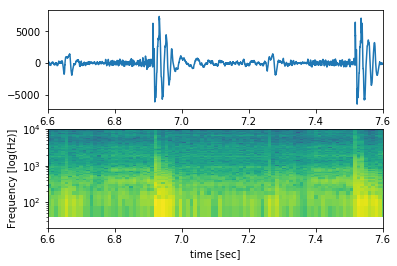

In [8]:
SEGMENT_LEN = 535
dat = data['record'][0]

def generate_spectrogram(data):
    '''
    Generates a spectrogram with logarithmically scaled frequency dimension.
    '''
    f, t, Sxx = signal.spectrogram(data,
                                 fs=FRAMERATE,
                                 scaling='density',
                                 mode='psd',
                                 nperseg=SEGMENT_LEN, 
                                 nfft=SEGMENT_LEN*2)
    Sxx = np.log(Sxx)
    return f, t, Sxx
    

f, t, Sxx = generate_spectrogram(dat)

fig, ax = plt.subplots(2,1)
ax[1].set_ylim((20, 10000))
# show two seconds of the signals spectrogram
ax[0].set_xlim((6.6, 7.6))
ax[1].set_xlim((6.6, 7.6))
# plot raw signal
ax[0].plot(samples_to_time(len(data['record'][0])), dat)
# plot spectrogram
ax[1].pcolormesh(t, f, Sxx, label='spectrogram i')
ax[1].set_yscale('log')
ax[1].set_xlabel("time [sec]")
ax[1].set_ylabel("Frequency [log(Hz)]")

# Frequency spectra

The frequency spectra show which frequencies are active in a given interval of the records. It is expected, that contacts further away from the motor produce relatively high frequencies compared to contacts closer to the motor.
The spectra below were generated using the welch method. It cuts its input into chunks and then returns the mean spectrum of those chunks.
The following plots allow the comparism of different spectra:
 - mean spectra that belong to the same speed, but different distances
 - mean spectra of the different used speeds within each distance

In [9]:
# data[data.distance == 11]['contacts_lst']

Text(0,0.5,'Frequency power')

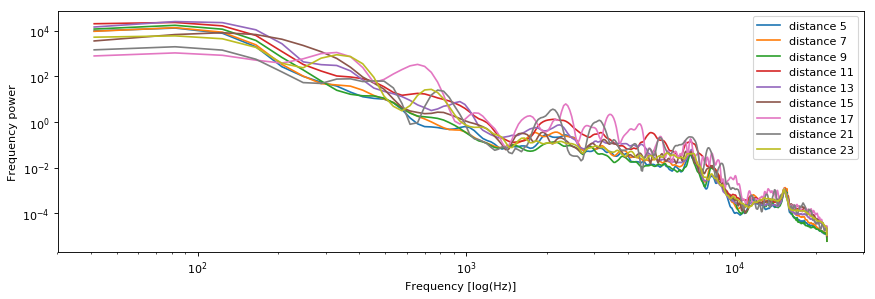

In [10]:
plt.figure(num=None, figsize=(13, 4), dpi=80)

def generate_spectrum(data):
    return signal.welch(data,
                           fs=FRAMERATE,
                           window='hann',
                           nperseg=SEGMENT_LEN,
                           nfft=SEGMENT_LEN*2)

# generate mean power spectra over every hit for each distance
# mean_spectra = pd.DataFrame()
total_powers = pd.DataFrame(columns=data['distance'].unique())
total_powers['speed'] = data['speed'].unique()
total_powers = total_powers.set_index('speed', drop=True)

freq_scale = []
power_spectra = []
distances = []
#pd_PSDs = pd.DataFrame()

for i in range(N_CLASSES):
    # get the time course of every contact related to one distance
    contacts = data['contacts_lst'][i]
    f, Pxx = generate_spectrum(contacts)
    # calculate the mean spectrum for one distance
    avg = np.mean(Pxx, axis=0)
    speed = data.loc[i, 'speed']
    distance = data.loc[i, 'distance']
    
    freq_scale = f
    power_spectra.extend(Pxx)
    distances = distances + [distance] * len(Pxx)
    
    # store the total power to a dataframe
    total_powers.loc[speed, distance] = avg.sum()
    std_dev = np.std(Pxx, axis=0)
    Pxx = 10 * np.log10(Pxx)
    #for pxx in Pxx:
    #    pd_PSDs.append([[distance, speed] + list(pxx)])
    if speed == 100:
        plt.plot(f, avg, label='distance %d' % distance)
    
    # mean_spectra[i] = avg
#pd_PSDs.columns = ['distance', 'speed'] + list(f.astype(str))
#pd_PSDs.to_csv('data/contact_snippets/contact_psds')
# plot last spectrum
#f, ax = plt.subplots()
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Frequency [log(Hz)]")
plt.ylabel("Frequency power")
# plt.plot(f, avg) #, std_dev)

It would be desirable that the frequencies wouldn't change much with just the changing motor speed, but exclusively with distance. The following plot shows mean spectra across all speeds for each distance. The standard deviation is partially really high, but that is due to the power that changes according to the speed. When using relative powers by deviding each spectrum by its total power, the standard deviation looks better. Still in the high freuency bands, there is a high deviation.

Text(0,0.5,'Frequency power')

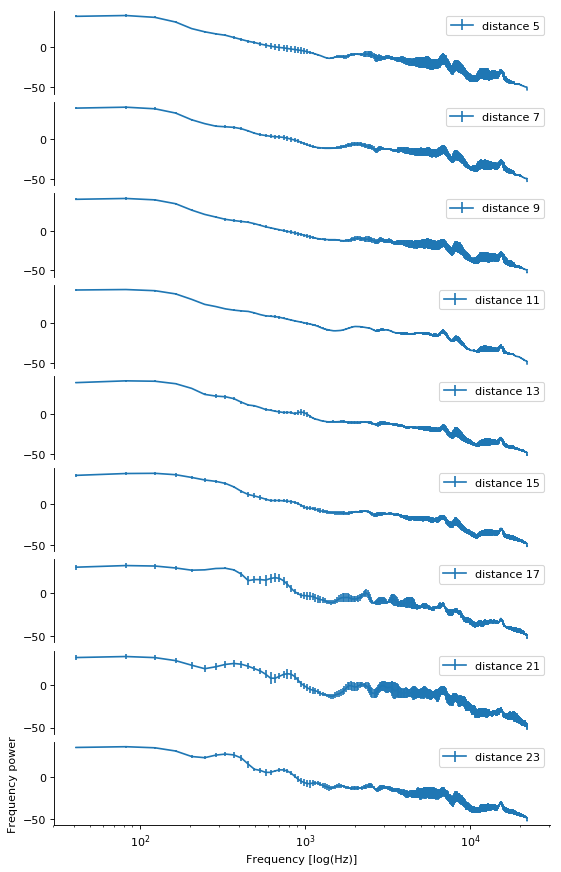

In [12]:
# generate spectra equal speed, varying distance
# generate spectra for different distances, taking the mean over the different speeds

plt.figure(num=None, figsize=(8, 15), dpi=80)
plt.subplots_adjust(hspace=0.1)
counter = 1

for dist in data.distance.sort_values().unique():
    df = data[data.distance == dist]
    averages = []
    for contacts in df['contacts_lst']:
        f, Pxx = generate_spectrum(contacts)
        Pxx = 10 * np.log10(Pxx)
        avg = np.mean(Pxx, axis=0)
        power = avg.sum()
        averages.append(avg)
    average = np.mean(averages, axis=0)
    std_dev = np.std(averages, axis=0)
    #std_dev[np.abs(std_dev) < 1e-5] = 1e-5
    #print(std_dev[:-10])
    ax = plt.subplot(10, 1, counter)
    plt.xscale('log')
    counter += 1
    plt.errorbar(f, average, yerr=std_dev, label='distance %d' % dist)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    if counter < 10:
        ax.spines['bottom'].set_visible(False)
        ax.get_xaxis().set_visible(False)
    plt.legend()
    
plt.legend()
plt.xlabel("Frequency [log(Hz)]")
plt.ylabel("Frequency power")

Text(0, 0.5, 'Frequency power')

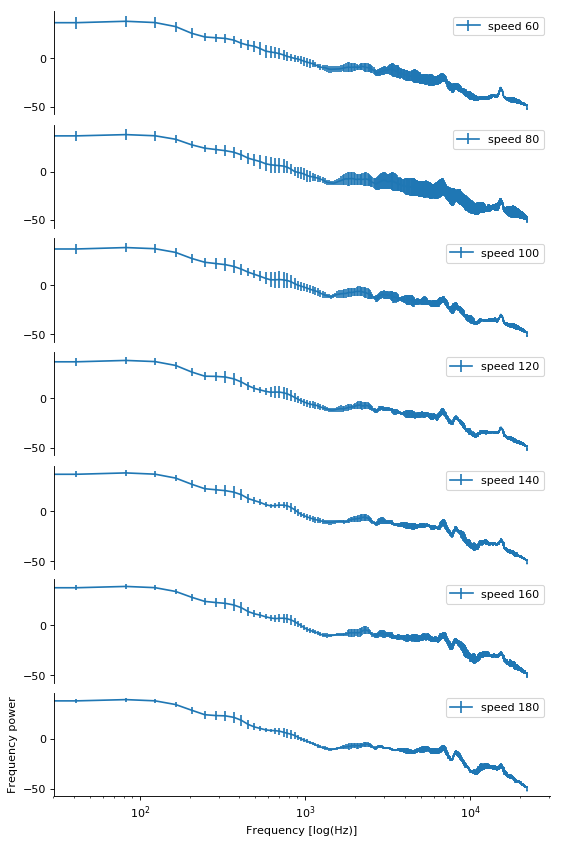

In [11]:
plt.figure(num=None, figsize=(8, 13), dpi=80)
plt.subplots_adjust(hspace=0.1)
counter = 1
for s in data.speed.sort_values().unique():
    fd = data[data.speed == s]
    averages = []
    for contacts in fd['contacts_lst']:
        f, Pxx = generate_spectrum(contacts)
        Pxx = 10 * np.log10(Pxx)
        avg = np.mean(Pxx, axis=0)
        power = avg.sum()
        averages.append(avg)
    average = np.mean(averages, axis=0)
    std_dev = np.std(averages, axis=0)
    ax = plt.subplot(7, 1, counter)
    plt.xscale('log')
    counter += 1
    ax.errorbar(f, average, std_dev, label='speed %d' % s)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    if counter <= 7:
        ax.spines['bottom'].set_visible(False)
        ax.get_xaxis().set_visible(False)
    plt.legend()
    


plt.xlabel("Frequency [log(Hz)]")
plt.ylabel("Frequency power")

## Eliminating the frequency power

The force of the contact and thus the power of the frequencies, depend on the motor velocity. To narrow the focus of the analysis on the frequencies, different approaches would be possible.

### Relative power
A solution could be to generate spectra of all contact records just like above, then calculate the overall power of each one by integration and devide the whole spectrum by that value. The problem with this approach is the noise which originally stays on a pretty constant level and by deviding it with the overall spectra power, it would change to different levels.

### Power relative to the angular motor velocity
Putting the overall spectral power in relation to the angular velocity of the motor for every distance, might solve this problem. The idea is to vary the motor velocity for every distance, such that each distance will produce an equally powerful spectrum. The plot below, correlates the total power of a contact-spectrum against the motor speed. Per distance, we get 5 different mean power spectra, that got produced using 7 different motor velocities.

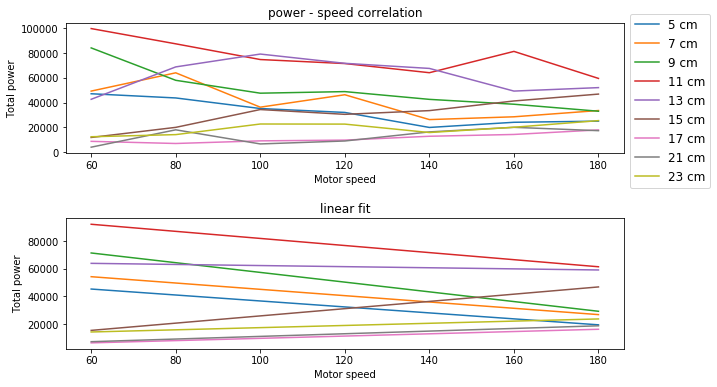

In [8]:
from scipy.stats import linregress
from matplotlib.font_manager import FontProperties

# set plot to a bigger size
fig, ax = plt.subplots(2,1, figsize=(10, 6))
ax[0].set_title("power - speed correlation")
ax[1].set_title("linear fit")

def lin_reg(xs, ys):
    '''
    Returns a linear regression between lowest and highest motor speed of
    the input arrays for first and second dimension.
    '''
    slope, intercept, r, p, sdterr = linregress(ms, tp)
    min_speed = data['speed'].min()
    max_speed = data['speed'].max()
    xs = np.array([min_speed, max_speed])
    return xs, slope * xs + intercept

# for every distance do an own plot
for distance in data['distance'].sort_values().unique():
    
    ms = total_powers[distance].index.tolist()        # every motor speed
    tp = total_powers[distance].tolist()              # total powers of the mean spectra for every speed
    ms, tp = zip(*sorted(zip(ms, tp)))                # sort both lists according to the motor speeds
    xs, ys = lin_reg(ms, tp)                          # fit a linear kurve
    
    ax[0].plot(ms, tp, label='%d cm' % distance)
    ax[1].plot(xs, ys, label='%d cm' % distance)
    # ax[1].axhline(77800, 0, 190, ls=':')

fontP = FontProperties()
fontP.set_size('large')
ax[0].set_xlabel("Motor speed")
ax[0].set_ylabel("Total power")
ax[1].set_xlabel("Motor speed")
ax[1].set_ylabel("Total power")
plt.subplots_adjust(hspace=.5)
plt.legend(loc='center left', bbox_to_anchor=(1, 1.9), prop=fontP)

This plot reveals, that the total power depents on the motor speed. This only applies to the first peak method, not to the last peak method. For this, the correlation is more chaotic.

### Support Vector Regression



In [3]:
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from tflearn.layers.core import fully_connected
#from sklearn.feature_selection import RFE
from joblib import Parallel, delayed
from sklearn import preprocessing
from sklearn import svm
import tensorflow as tf
import multiprocessing

pd_PSDs = pd.read_csv('data/contact_snippets/contact_psds')
pd_PSDs = pd_PSDs.sort_values(by=['distance','speed'])
pd_PSDs['id'] = range(len(pd_PSDs))
pd_PSDs = pd_PSDs.set_index('id', drop=True)

X = pd_PSDs.loc[:, '0.0': ]
yD = pd_PSDs['distance'].tolist()
yS = pd_PSDs['speed'].tolist()
yS = np.reshape(yS, [-1, 1])
yS = preprocessing.StandardScaler().fit(yS).transform(yS)
X = preprocessing.StandardScaler().fit(X.transpose()).transform(X.transpose()).transpose()

X_train, X_test, y_train, y_test = train_test_split(X, yD, test_size=0.33)

hdf5 is not supported on this machine (please install/reinstall h5py for optimal experience)


/home/luca/Documents/bachelor_thesis/GitHub/PiezoAntenna/venv/lib/python3.5/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [8]:
model = svm.SVR(kernel='poly', degree=9, epsilon=.5,C=10.) # poly degree 10 --> 94 %
model.fit(X_train, y_train)

prediction = model.predict(X_test)
score = model.score(X_test, y_test)
score

0.949524890378935

In [104]:
ANTENNA_LENGTH = 23.#cm

# X has a total amount of 536 values
x = tf.placeholder(tf.float32, shape=[None, 536, 1])
y = tf.placeholder(tf.float32, shape=[None, 1])

def conv(in_data, kernel, stride=1):
    convolution = tf.nn.conv1d(in_data, kernel, stride=stride, padding='SAME')
    pool = tf.layers.max_pooling1d(convolution, 3, 2)
    return pool

# build net
weights = { 'W1' : tf.Variable(tf.random_normal([3, 1, 32])),
            'W2' : tf.Variable(tf.random_normal([5, 32, 64])),
            'W3' : tf.Variable(tf.random_normal([4, 64, 64])),}

conv1 = conv(x, weights['W1'], 2)
conv2 = conv(conv1, weights['W2'], 4)
conv3 = conv(conv2, weights['W3'], 2)
fc1   = tf.layers.flatten(conv3)
print(fc1)
# do    = tf.nn.dropout(fc1, 0.8)
fc2   = fully_connected(fc1, 128, activation=tf.nn.relu)
fc3   = fully_connected(fc2, 128, activation=tf.nn.relu)

# output a percentage along the antenna
sample = fully_connected(fc3, 1, activation=tf.nn.relu)

loss = tf.losses.mean_squared_error(sample, y)
train = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(loss)

Tensor("flatten_23/Reshape:0", shape=(?, 192), dtype=float32)


Iteration 0 finished with mean error 17.38969
Iteration 10 finished with mean error 2.28607
Iteration 20 finished with mean error 1.24202
Iteration 30 finished with mean error 0.71346
Iteration 40 finished with mean error 0.42127
Accuracy	0.6015625
Difference	1.1882679253595219
R2 Score	0.9652846661109272
Contact at 5 cm < - > 4.9725 cm prediction
Contact at 9 cm < - > 9.9439 cm prediction
Contact at 5 cm < - > 5.2693 cm prediction
Contact at 7 cm < - > 6.8461 cm prediction
Contact at 9 cm < - > 12.0248 cm prediction
Contact at 11 cm < - > 12.1607 cm prediction
Contact at 13 cm < - > 13.9430 cm prediction
Contact at 11 cm < - > 9.5296 cm prediction
Contact at 13 cm < - > 13.9184 cm prediction
Contact at 21 cm < - > 21.6702 cm prediction
Mean Divergence	0.8086000197549575


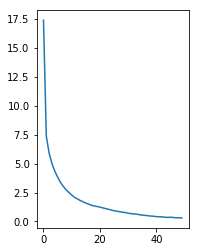

In [105]:
### num_epochs = 50
batch_size = 5

tf.set_random_seed(42)

init = tf.global_variables_initializer()

loss_summary = []
with tf.Session() as sess:
    
    sess.run(init)
    
    for i in range(num_epochs):
        
        epoch_mse = []
        
        for index, offset in enumerate(range(0, len(X_train), batch_size)):
            xs = X_train[offset:offset+batch_size]
            xs = np.reshape(xs, [len(xs), len(xs[0]), 1])
            ys = y_train[offset:offset+batch_size]
            ys = np.reshape(ys, [len(xs), 1])
            t, mse, s = sess.run([train, loss, sample], feed_dict={ x : xs, y : ys })
            epoch_mse.append(mse)
            
        if i % 10 == 0:
            print('Iteration {} finished with mean error {:.5f}'.format(i, np.mean(epoch_mse)))
        
        loss_summary.append(np.mean(epoch_mse))
    
    predictions = []

    X_test = np.reshape(X_test, [-1, len(X_test[0]), 1])
    y_test = np.reshape(y_test, [-1, 1])
    for i in range(len(X_test)):
        p = sess.run(sample, feed_dict={ x : [X_test[i]], y : [y_test[i]] })
        predictions.append(p)

    predictions = np.ravel(predictions)
    false_predictions = np.sum([ (p - t) > 0.2 for p, t in zip(predictions, y_test)  ])

    accuracy = float(len(predictions)) / float((len(predictions) + false_predictions))

    print('Accuracy\t{}'.format(accuracy))
    
    difference = np.mean(np.power(np.subtract(predictions, np.ravel(y_test)), 2))
    print('Difference\t{}'.format(difference))
    
    r2 = r2_score(np.ravel(y_test), predictions)
    print('R2 Score\t{}'.format(r2))
        
plt.subplot(1, 2, 1)
plt.plot(loss_summary)
for i in range(10):
    print("Contact at {} cm < - > {:.4f} cm prediction".format(np.ravel(y_test)[i], predictions[i]))
print("Mean Divergence\t{}".format(np.mean(np.abs(np.ravel(y_test) - predictions))))

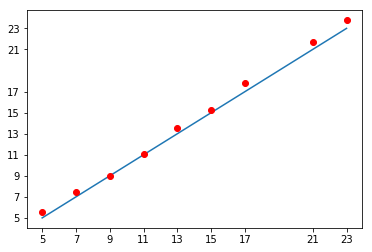

In [106]:
#plt.plot(y_test, predictions)
# sort predictions
sorted_predictions = [x for _,x in sorted(zip(y_test, predictions))]
ys = np.reshape(sorted(y_test), [len(y_test)])
last_y = ys[0]
means = [sorted_predictions[0]]
mean_prediction = []
for i in range(1, len(ys)):
    if last_y != ys[i]:
        mean_prediction.append(np.mean(means))
        means = []
    last_y = ys[i]
    means.append(sorted_predictions[i])
mean_prediction.append(np.mean(means))
plt.xticks(np.unique(ys))
plt.yticks(np.unique(ys))
plt.plot([5, 23], [5, 23])
plt.plot(np.unique(ys), mean_prediction, 'ro')

### Systematic search for the optimal frequency band for prediction

First large frequency bands should be searched for best performance. The best performing one gets split up further until there is decrease in performance. For this task neural nbetworks need to be autogenerated to match the size of the input and the weight initializer should be somewhat constant. So a random seed gets set.

In [116]:
def get_score(_xi, _yi, xtest, ytest):
    model = svm.SVR(kernel='rbf', epsilon=.5, C=10.) # poly degree 10 --> 94 %
    model.fit(_xi, _yi)

    prediction = model.predict(xtest)
    score = model.score(xtest, ytest) # mean_absolute_error(y_test, prediction)
    return score


FILTER_DECAY = 4
FILTER_STEP = 2
total_data_size = len(X_train[0])
initial_filter_size = total_data_size - FILTER_DECAY
best_scores = []
iterations_data = pd.DataFrame()


# setup initial scanning range
start_range = 0
filter_size = initial_filter_size
end_range = total_data_size

while (end_range - start_range) >= 5:
    
    iteration_scores = []
    
    # find optimum range with a minimum size of 5
    for i in range(int(FILTER_DECAY / FILTER_STEP) + 1):
        # extract region for training
        start = start_range + i * FILTER_STEP
        end = start + filter_size
        xtrain = X_train[ : , start : end]
        xtest = X_test[ : , start : end]
        # train and eval model
        s = get_score(xtrain, y_train, xtest, y_test)
        iteration_scores.append([s, start, end])
        
    # append scores to total interations data
    best_start_idx = np.argmax(np.array(iteration_scores)[:, 0:1])
    # find best performing range
    best = iteration_scores[best_start_idx]
    # set new start and end
    start_range, end_range = best[1], best[2]
    filter_size = filter_size - FILTER_DECAY
    print("Iteration finished {}\n\t--> best\tscore\t{}\n\t\t\tstart\t{}\n\t\t\tend\t{}"
          .format(iteration_scores, *best))
    
    iterations_data = iterations_data.append(iteration_scores)


iterations_data.columns = ['score', 'start_freq', 'end_freq']
iterations_data

In [1]:
m = svm.SVR(kernel='linear')
#selector = RFE(m, 100, step=1)
#selector = selector.fit(X_train, y_train)
# summarize the selection of the attributes
#print(rfe.support_)
#print(rfe.ranking_)

NameError: name 'svm' is not defined

In [123]:
# generate ranges
freq_bands = []
for s in range(0, len(X_train[0]), 8):
    for e in reversed(range(s+1, len(X_train[0]), 8)):
        freq_bands.append([s, e])
print("Number of frequency bands to test: %d" % len(freq_bands))

Number of frequency bands to test: 2278


In [34]:
def probe_range(band):
    percentage = float(freq_bands.index(band)) / len(freq_bands) * 100
    print('\033[92mPercent done: {:.2f} %\033[0m  --->  Probing {} - {}'
          .format(percentage, band[0], band[1]))
    xtrain = X_train[ : , band[0] : band[1] ]
    xtest = X_test[ : , band[0] : band[1] ]
    return [ get_score(xtrain, y_train, xtest, y_test), band[0], band[1] ]

num_cores = multiprocessing.cpu_count()
results = Parallel(n_jobs=num_cores)(delayed(probe_range)(r) for r in freq_bands)

In [119]:
#idx_best = np.argmax(np.array(results)[:, 0])
#results[:5]

In [38]:
r = pd.DataFrame(results)
r.to_csv('data/analysis/freq_bands_performance_svr')

### Support Vector regression

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.preprocessing import scale
from IPython.display import clear_output

kernel='rbf'
degree=3
gamma='auto'
coef0=0.0
tol=0.001
C=10
epsilon=.5
shrinking=True
cache_size=500
verbose=True
max_iter=-1

#svm.SVR(kernel='rbf',epsilon=5,C=100) #,gamma=1./47)
model = SVR(kernel=kernel, epsilon=epsilon)
#, degree=degree, gamma=1./47, coef0=coef0, tol=tol, C=C, , shrinking=shrinking, cache_size=cache_size, verbose=verbose, max_iter=-max_iter

#for dataset in datasets:

def get_freq_index(freq):
    return (np.abs(freq_scale - freq)).argmin()

# generate freq ranges
ranges = []
for f1 in range(len(freq_scale)):
    for f2 in range(f1 + 1, len(freq_scale)):
        ranges.append([f1, f2])

results = []
count = 1
for r in ranges:
    clear_output(wait=True)
    print("Processing... {:.2f}%".format(count*100./len(ranges)))
    X = np.array(power_spectra)[:,r[0]:r[1]] # dataset['X'][0]
    X = scale(X, axis=1)

    y = distances # dataset['y']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    results.append([r[0], r[1], score])
    count += 1

sorted(results, key=lambda x: x[3], reverse=True)
for i in range(10):
    print("R²-Score of range from {:.3f} Hz to {:.3f} Hz is {:.3f}".format(results[0], results[1] ,results[2]))


NameError: name 'freq_scale' is not defined

In [22]:
freq_bands_performance = pd.read_csv('data/analysis/freq_bands_performance_svr')
freq_bands_performance.columns = ['index', 'score', 'start', 'end']
freq_bands_performance.sort_values(by='score', ascending=False).head(10)

,index,score,start,end
117,117,0.909824,0,65
116,116,0.908420,0,69
127,127,0.907964,0,25
126,126,0.907186,0,29
115,115,0.906635,0,73
118,118,0.906529,0,61
61,61,0.904847,0,289
60,60,0.904706,0,293
114,114,0.904645,0,77
119,119,0.904404,0,57


In [43]:
pd_PSDs.columns[3]
range(int(np.ceil(np.log10(500))))
pd_PSDs.columns

Index(['Unnamed: 0', 'distance', 'speed', '0.0', '41.21495327102804',
       '82.42990654205607', '123.64485981308411', '164.85981308411215',
       '206.07476635514018', '247.28971962616822',
       ...
       '21679.065420560746', '21720.280373831774', '21761.495327102803',
       '21802.71028037383', '21843.92523364486', '21885.140186915887',
       '21926.355140186915', '21967.570093457944', '22008.78504672897',
       '22050.0'],
      dtype='object', length=539)

In [86]:
NUM_EPOCHS = 20
batch_size = 10
num_features = len(X_train[0])
tf.set_random_seed(42)
nn_performances = pd.DataFrame()

X_test = np.reshape(X_test, [-1, len(X_test[0]), 1])
y_test = np.reshape(y_test, [-1, 1])

weights = { 0 : tf.Variable(tf.random_normal([3, 1, 32])),
            1 : tf.Variable(tf.random_normal([5, 32, 64])),
            2 : tf.Variable(tf.random_normal([6, 64, 32])),}

def conv(in_data, kernel, stride=1):
    convolution = tf.nn.conv1d(in_data, kernel, stride=stride, padding='SAME')
    return convolution

def build_network(x_in, in_size):
    c_prev = x_in
    for i in range(int(np.ceil(np.log10(in_size)))):
        c_prev = conv(c_prev, weights[i], int(np.shape(weights[i])[0])-1) # TODO : Put length of filter -1
        
    fc0   = tf.layers.flatten(c_prev)
    fc_prev = fc0
    
    for i in range(int(np.ceil(np.log10(in_size)))):
        fc_prev   = fully_connected(fc_prev, int(int(np.shape(fc_prev)[1])/2.), activation=tf.nn.relu)
    sample = fully_connected(fc_prev, 1, activation=tf.nn.relu)
    
    return sample

def test_performance(low_index, hi_index):
    in_size = hi_index - low_index
    x = tf.placeholder(tf.float32, shape=[None, in_size, 1])
    y = tf.placeholder(tf.float32, shape=[None, 1])
    predictions = build_network(x, in_size)
    loss = tf.losses.mean_squared_error(y, predictions)
    train = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(loss)
    init = tf.global_variables_initializer()
    # run train and test op
    with tf.Session() as sess:
        sess.run(init)
        for i in range(NUM_EPOCHS):
            epoch_mse = []
            for index, offset in enumerate(range(0, len(X_train), batch_size)):
                # select features and produce batch
                xs = X_train[offset:offset+batch_size, low_index : hi_index]
                xs = np.reshape(xs, [len(xs), len(xs[0]), 1])
                ys = y_train[offset:offset+batch_size]
                ys = np.reshape(ys, [len(xs), 1])
                t, mse = sess.run([train, loss], feed_dict={ x : xs, y : ys })
                epoch_mse.append(mse)
        xtest = X_test[:, low_index : hi_index]
        test_mse, pred = sess.run([loss, predictions], feed_dict={ x : xtest, y : y_test })
        r2 = r2_score(np.ravel(y_test), np.ravel(pred))
    return { 'low_freq' : pd_PSDs.columns[low_index+3],
             'hi_freq' : pd_PSDs.columns[hi_index+3],
             'mean_error_last_epoch' : np.mean(epoch_mse),
             'test_error' : test_mse,
             'r2_score' : r2 }

# test_performance('0.0', '22050.0')
frequencies = range(0, num_features, 10)
performances = pd.DataFrame()
for lo in frequencies:
    for hi in range(lo+1, num_features, 10):
        performances = performances.append(test_performance(lo, hi), ignore_index=True)
        print('Evaluating range %.2f - %.2f\t r2 --> %.4f' % (float(pd_PSDs.columns[lo + 3])
                                                          ,float(pd_PSDs.columns[hi + 3])
                                                          ,performances['r2_score'].iloc[-1]))
        #freq_ranges.append([lo, hi])
def eval_range(freq_range):
        return test_performance(lo, hi)
        
        
tp = Parallel(n_jobs=2, prefer="threads")(delayed(sqrt)(i ** 2) for i in range(10))

Evaluating range 0.00 - 41.21	 r2 --> -2.7826
Evaluating range 0.00 - 453.36	 r2 --> 0.7787


KeyboardInterrupt: 

In [13]:

len(X_test[0])

536